In [27]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [28]:
alphas = pd.read_csv("parameters.csv")

In [29]:
longs = alphas[alphas["Alpha"] > 0]["Ticker"].tolist()
shorts = alphas[alphas["Alpha"] < 0]["Ticker"].tolist()

In [30]:
def load_returns(ticker):
    path = f"returns/{ticker}.csv"
    try:
        df = pd.read_csv(path)
        return df["Excess"].reset_index(drop=True)
    except Exception:
        print(f"Warning: Missing data for {ticker}")
        return None

In [31]:
long_returns = []
short_returns = []

for t in longs:
    r = load_returns(t)
    if r is not None:
        long_returns.append(r)

for t in shorts:
    r = load_returns(t)
    if r is not None:
        short_returns.append(r)

In [32]:
long_df = pd.concat(long_returns, axis=1)
short_df = pd.concat(short_returns, axis=1)

In [33]:
portfolio_long = long_df.mean(axis=1)
portfolio_short = short_df.mean(axis=1)

In [34]:
long_short = portfolio_long - portfolio_short

In [35]:
cumulative = (1 + long_short).cumprod()

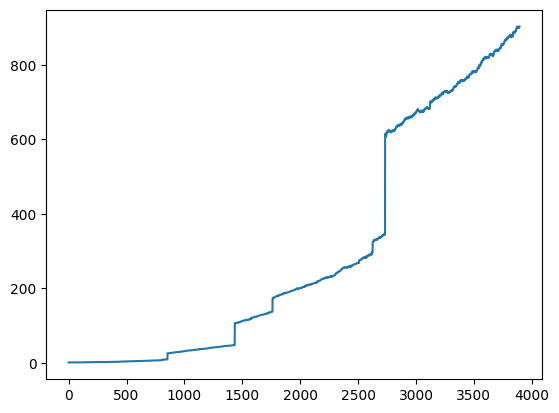

In [36]:
plt.plot(cumulative)